# **Fake News Classification Model**

This model provides a hands on process to build a fake news classification model from scratch. Therefor we are provided with a training dataset, a validation dataset and a testing dataset. To build this model we will use a pre-trained Transformer Model - BERT

# **Loading the Datasets and transforming into Dataframes**

In [1]:
from google.colab import drive
drive.mount('/content/Drive')
training_file = '/content/Drive/MyDrive/YourPath/train_dataset.csv'
validation_file = '/content/Drive/MyDrive/YourPath/validation_dataset.csv'
test_file = '/content/Drive/MyDrive/YourPath/test_dataset.csv'

Mounted at /content/Drive


In [2]:
import pandas as pd

In [3]:
df_train = pd.read_csv(training_file, sep=';', index_col=0)
df_validation = pd.read_csv(validation_file, sep=';', index_col=0)
df_test = pd.read_csv(test_file, sep=';', index_col=0)

## **Data Preprocessing**
- Checking the Dataset for Data-Types, Missing Data and Duplicates
- Get a Feeling for the Balance of the Labels (Fake-News vs. Non-Fake-News)
- Clean title-text and text-text form HTML-tags, URLs, Stopwords and unnecessary blanks
- Combine title and text column for more context

In [4]:
# Data Types, missing data, duplicates
from IPython.display import display_html

def check_dataframes(df):
    df_info = pd.DataFrame({
        "Column": df.columns,
        "Dtype": [df[col].dtype for col in df.columns]
    })

    df_nan = pd.DataFrame(df.isnull().sum(), columns=["Missing Values"]).reset_index()
    df_nan.columns = ["Column", "Missing Values"]
    df_duplicates = pd.DataFrame([df.duplicated().sum()], columns=["Duplicate Count"])

    return df_info, df_nan, df_duplicates

df_info, df_nan, df_duplicates = check_dataframes(df_train) # just use every dataframe from above to check

display_html(f"""
<div style="display: flex; gap: 20px;">
    <div style="margin-right: 20px;">{df_info.to_html(index=False)}</div>
    <div style="margin-right: 20px;">{df_nan.to_html(index=False)}</div>
    <div>{df_duplicates.to_html(index=False)}</div>
</div>
""", raw=True)

Column 
 Dtype 
 
 
 
 
 title 
 object 
 
 
 text 
 object 
 
 
 label 
 int64 
 
 
 
 
 
 
 Column 
 Missing Values 
 
 
 
 
 title 
 0 
 
 
 text 
 0 
 
 
 label 
 0 
 
 
 
 
 
 
 Duplicate Count 
 
 
 
 
 1

In [5]:
# Label balance
def check_label_balance(df, label_column):
  label_counts = df[label_column].value_counts()
  print("Label Distribution:")
  print(label_counts)
  print("\nClass Balance Ratio:")
  for label, count in label_counts.items():
      print(f"Class {label}: {count / len(df):.2%}")

check_label_balance (df_train, 'label')

Label Distribution:
label
1    13246
0    11107
Name: count, dtype: int64

Class Balance Ratio:
Class 1: 54.39%
Class 0: 45.61%


- Just try the functions for each dataset

In [6]:
# Cleaning and combining the text
import re
from collections import Counter

def clean_text(text):
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Delete URLs
  text = re.sub(r'<.*?>', '', text)   # Delete HTML-tags
  text = re.sub(r"[^a-zA-Z\s]", '', text) # Delete special character
  text = re.sub(r'\s+', ' ', text).strip() # Delete blanks
  text = text.lower() # # Convert to lower cases
  return text

def preprocess_dataframe(df):
  df['cleaned_title'] = df['title'].apply(clean_text)
  df['cleaned_text'] = df['text'].apply(clean_text)
  df['combined_text'] = df['cleaned_title'] + " " + df['cleaned_text']
  df= df.drop(['title','text','cleaned_title', 'cleaned_text'], axis=1)
  df= df[['combined_text', 'label']]
  return df

df_train = preprocess_dataframe(df_train)
df_validation = preprocess_dataframe(df_validation)
df_test = preprocess_dataframe(df_test)

In [7]:
df_train

,combined_text,label
0,palestinians switch off christmas lights in be...,1
1,china says trump call with taiwan president wo...,1
2,fail the trump organizations credit score will...,0
3,zimbabwe military chiefs china trip was normal...,1
4,the most uncourageous president ever receives ...,0
...,...,...
24348,mexico senate committee oks air transport deal...,1
24349,breaking hillary clintons state department gav...,0
24350,trump breaks from stump speech to admire beaut...,0
24351,nfl player delivers courageous message stop bl...,0


# **Numeric representation of the Text-Data**

Because we will use a Transformer Model, we use a specialized Tokenizer from Bert


In [9]:
from transformers import BertTokenizer
import numpy as np

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased") # Load tokenizer

# Tokenizing function
def tokenize_data(df, tokenizer, max_length=200):
    return tokenizer(
        list(df["combined_text"]),  # Convert text into a list
        padding=True,               # Activate padding aktivieren
        truncation=True,            # Length limitation
        max_length=max_length,      # Max sequence length
        return_tensors="tf"         # return a tensor
    )

# Tokenizing for all dataframes
train_encodings = tokenize_data(df_train, tokenizer)
validation_encodings = tokenize_data(df_validation, tokenizer)
test_encodings = tokenize_data(df_test, tokenizer)

# Label extraction
train_labels = np.array(df_train["label"], dtype=np.int32)
validation_labels = np.array(df_validation["label"], dtype=np.int32)
test_labels = np.array(df_test["label"], dtype=np.int32)


# **Load Transformer Model (BERT-Modell)**

In [10]:
from transformers import TFBertForSequenceClassification, create_optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam


model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2) # Load model
loss_fn = SparseCategoricalCrossentropy(from_logits=True)

# Optimizer with Hugging Face
batch_size = 16
num_train_steps = int(len(train_labels) / batch_size * 3)  # 3 epochs
optimizer, schedule = create_optimizer(
    init_lr=5e-5,  # Start learning rate
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"]) # Compiling
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **Model Training**

In [11]:
history = model.fit(
    x={
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"]
    },
    y=train_labels,
    validation_data=(
        {
            "input_ids": validation_encodings["input_ids"],
            "attention_mask": validation_encodings["attention_mask"]
        },
        validation_labels
    ),
    epochs=3,
    batch_size=16
)



Epoch 1/3
1523/1523 [==============================] - 1223s 771ms/step - loss: 0.0576 - accuracy: 0.9781 - val_loss: 0.0370 - val_accuracy: 0.9872
Epoch 2/3
1523/1523 [==============================] - 1156s 759ms/step - loss: 0.0250 - accuracy: 0.9909 - val_loss: 0.0383 - val_accuracy: 0.9864
Epoch 3/3
1523/1523 [==============================] - 1179s 774ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0341 - val_accuracy: 0.9899


# **Model evaluation**

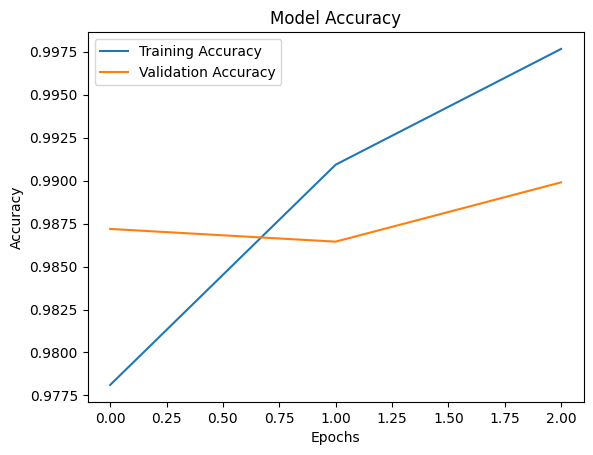

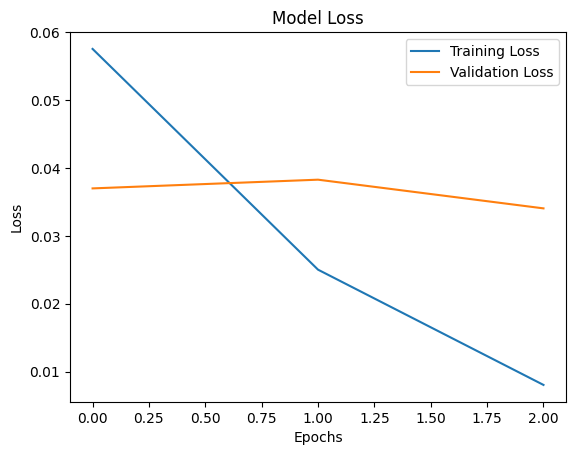

In [14]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [12]:
# Model on test dataset
import numpy as np
from sklearn.metrics import classification_report

test_predictions = model.predict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}).logits

test_predictions = np.argmax(test_predictions, axis=1)

print("Test Predictions Shape:", test_predictions.shape)
print("Test Labels Shape:", test_labels.shape)


254/254 [==============================] - 117s 449ms/step
Test Predictions Shape: (8117,)
Test Labels Shape: (8117,)


In [13]:
from sklearn.metrics import classification_report

# Classification report
print(classification_report(test_labels, test_predictions, target_names=["Not Fake", "Fake"]))


              precision    recall  f1-score   support

    Not Fake       0.99      0.99      0.99      3753
        Fake       0.99      0.99      0.99      4364

    accuracy                           0.99      8117
   macro avg       0.99      0.99      0.99      8117
weighted avg       0.99      0.99      0.99      8117



In [ ]:
model.save_pretrained("fake_news_classifier")
tokenizer.save_pretrained("fake_news_classifier")


# **Model testing**

In [26]:
def preprocess_new_text(title, text):
    cleaned_title = clean_text(title)
    cleaned_text = clean_text(text)
    combined_text = cleaned_title + " " + cleaned_text
    return combined_text


In [32]:
def tokenize_new_text(combined_text, tokenizer, max_length=200):
    return tokenizer(
        combined_text,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [56]:
title = "Breaking News: Trump Revealed as an Alien Planning to Take Over the World"
text = """
    NEW YORK (Reuters) -In a shocking revelation that has left the world in disbelief, scientists and intelligence agencies have uncovered what
    might be the most extraordinary secret in human history: Donald J. Trump, the former President of the United States, is allegedly not of this Earth.
    Sources close to the investigation claim that Trump hails from a distant galaxy, sent here with a singular mission – to conquer the world and establish an
    intergalactic empir.

    """

combined_text = preprocess_new_text(title, text)
encoding = tokenize_new_text(combined_text, tokenizer)

logits = model.predict({
    "input_ids": encoding["input_ids"],
    "attention_mask": encoding["attention_mask"]
}).logits

logits


1/1 [==============================] - 0s 139ms/step


array([[-5.190196 ,  4.5959883]], dtype=float32)

In [57]:
predicted_label = np.argmax(logits, axis=1)[0]
predicted_label

1

In [59]:
predicted_label = np.argmax(logits, axis=1)[0]
result = "Fake News" if predicted_label == 1 else "Not Fake News"
print(f"The text you are reading is: {result}")

The text you are reading is: Fake News
